In [1]:
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import classification_report

C:\Users\jenni\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
secom_df = np.loadtxt('./secom.data', dtype=str) 
secom_df = pd.DataFrame(preprocessing.scale(secom_df)) #scaling and Data Frame

target = np.loadtxt('./secom_labels.data', dtype=str)

target = pd.DataFrame(target) #Data Frame
times = target[2].str.split(':', expand=True)[0]
time_df = pd.DataFrame(times)
target = target[0].astype(int)
time_df['FPY']=target
labels_df=target

How many observations and features are there?

In [3]:
print('features',secom_df.shape) #590 features, 1567 observations
print('time',times.shape)
print('labels',labels_df.shape)

#sns.histplot(data = labels_df, color= 'grey')
labels_df.value_counts()

features (1567, 590)
time (1567,)
labels (1567,)


-1    1463
 1     104
Name: 0, dtype: int64

look at the data

In [4]:
print(secom_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB
None


In [5]:
secom_df.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,0.223879,0.847825,-0.434320,0.033405,-0.050354,0.0,-0.561266,0.265504,0.509501,1.127696,...,NaN,NaN,0.118661,-0.204825,-0.093178,-0.197050,NaN,NaN,NaN,NaN
1,1.105015,-0.382054,1.012583,0.152382,-0.059776,0.0,0.197330,0.321317,0.456708,0.022567,...,0.194011,1.260949,0.530034,0.406549,0.444564,0.384936,-0.959868,0.411722,0.250045,1.156320
2,-1.112023,0.797316,-0.479135,0.683141,-0.047691,0.0,-0.902153,0.254341,-0.260740,0.326974,...,3.020445,-0.172375,-1.262377,0.022257,0.014371,0.029823,2.990196,3.625906,3.320359,-0.179091
3,-0.349640,-0.198431,-0.051316,-1.101992,-0.051060,0.0,0.500993,-0.013563,0.342999,-0.764920,...,-0.319886,-0.275485,-0.322096,-0.292164,-0.362049,-0.283326,-0.101862,-0.178870,-0.308194,-0.275158
4,0.241679,0.087330,1.112384,-0.158208,-0.047280,0.0,-0.114865,0.187365,0.544697,-0.149489,...,NaN,NaN,-5.905014,26.858657,27.062785,26.904758,-0.101862,-0.178870,-0.308194,-0.275158


How do you plan to handle missing values?

In [6]:
print(secom_df.isna().any().any()) 

True


In [7]:
#https://www.elektormagazine.de/articles/datenanalyse-und-knstliche-intelligenz-in-python
na_cols = [col for col in secom_df.columns if secom_df[col].isnull().sum() / len(secom_df) > 0.4]
secom_df = secom_df.drop(na_cols, axis=1)
secom_df.shape

(1567, 558)

In [8]:
#imputer = SimpleImputer(strategy='mean')
imputer = KNNImputer(n_neighbors=8, weights="uniform")
secom_imputed = pd.DataFrame(imputer.fit_transform(secom_df))
secom_imputed.columns = secom_df.columns
secom_df=secom_imputed

In [9]:
print(secom_df.isna().any().any())

False


Check for trends and outliers

In [10]:
secom_df.describe() #there are outliers
#Standartesierung Notwendig

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1.567000e+03,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,-0.001489,0.000478,-0.000120,0.000543,0.018431,0.0,-0.003865,-0.012566,-0.000938,-0.000134,...,-4.676469e-16,-3.101398e-15,0.000331,-0.000073,-0.000055,-0.000073,-0.000567,0.000218,0.000268,0.000363
std,0.998848,0.998405,0.998307,0.996896,1.084376,0.0,0.997346,1.062508,1.000049,0.999735,...,1.000319e+00,1.000319e+00,1.000086,1.000004,1.000002,1.000004,1.000252,1.000037,1.000056,1.000103
min,-3.685048,-4.193732,-4.741357,-3.162447,-0.062401,0.0,-3.044296,-13.598515,-3.680125,-3.478111,...,-2.896758e-01,-9.662759e-01,-6.551457,-0.542536,-0.577145,-0.522892,-3.104882,-1.507703,-1.494452,-1.061880
25%,-0.654947,-0.534514,-0.661034,-0.708829,-0.056433,0.0,-0.518846,-0.080539,-0.700685,-0.659039,...,-2.456434e-01,-4.118818e-01,-0.645317,-0.216470,-0.200726,-0.212846,-0.652281,-0.667245,-0.691984,-0.589179
50%,-0.048002,0.043539,0.017604,-0.246910,-0.051124,0.0,0.060831,0.064576,-0.018432,-0.030373,...,-2.328715e-01,-2.262959e-01,0.030510,-0.088373,-0.066291,-0.086731,-0.077579,-0.190228,-0.238415,-0.294550
75%,0.571850,0.533761,0.593424,0.440188,-0.047356,0.0,0.548032,0.220853,0.730827,0.611528,...,-2.164669e-01,3.513558e-02,0.662261,0.068838,0.068145,0.063498,0.497123,0.434437,0.389604,0.160658
max,4.645455,4.361550,3.888312,5.251202,19.708750,0.0,4.512970,0.756660,2.619881,5.012191,...,5.016547e+00,6.435055e+00,2.851353,26.858657,27.062785,26.904758,6.584107,7.203531,8.135170,6.793326


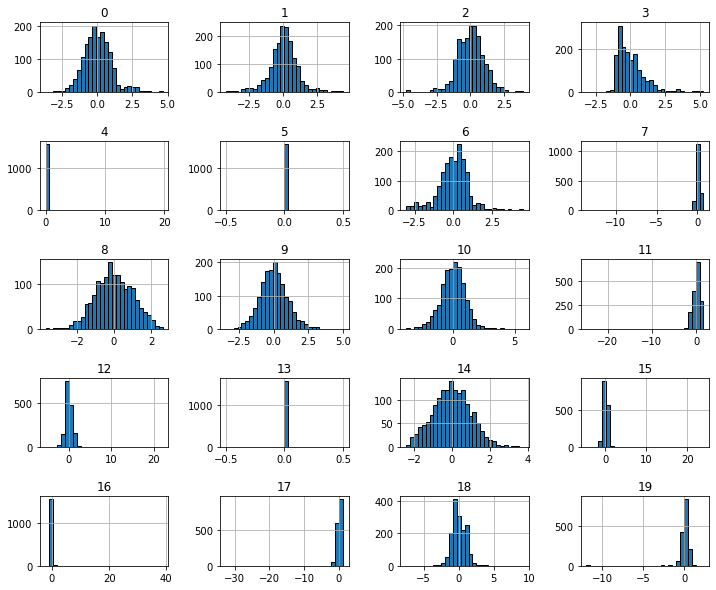

In [11]:
pd.DataFrame(np.array(secom_df)[:,0:20]).hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
#es gibt Konstanten #sehe auch in der Beschreibung der Daten

In [12]:
#Entferne Konstanten
secom_df=secom_df.loc[:, (secom_df != secom_df.iloc[0]).any()]
secom_df.shape

(1567, 442)

Are there redundant features?

<AxesSubplot:>

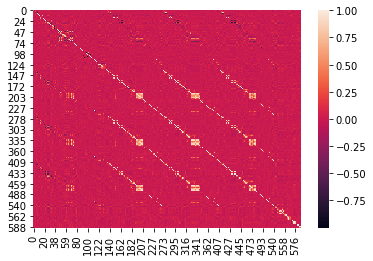

In [13]:
sns.heatmap(secom_df.corr())
#es existiert eine Korrelation, also es gibt in den Daten redundante Werte

In [14]:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python#mcetoc_1g0c4fnd4a
df= secom_df
cor_matrix = df.corr(method="spearman").abs()
#print(cor_matrix)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
upper_tri.set_axis(list(range(0,secom_df.shape[1])), axis=1,inplace=True)
#print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
secom_df = df.drop(df.columns[to_drop], axis=1) # geht nur ein mal
#print(secom_df.head())
secom_df.shape #Redundante Werte sind entfernt

(1567, 369)

feature importances

In [15]:
# ANOVA feature selection for numeric input and categorical output
k=40
# define feature selection ANOVA entspricht Ftest
fs = SelectKBest(score_func=f_classif, k=k)
# apply feature selection 
secom_df = pd.DataFrame(fs.fit_transform(secom_df, labels_df))
print(secom_df.shape)

(1567, 40)


In [26]:
secom_df.keys() #->key falsch gesetzt

RangeIndex(start=0, stop=40, step=1)

Aufgabe 2

Are there specific times with a higher rate of errors?

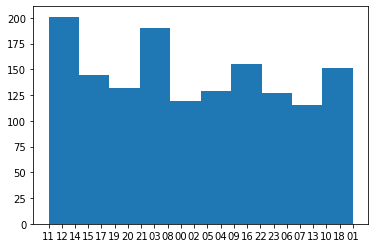

In [17]:
target2 = np.loadtxt('./secom_labels.data', dtype=str)
target2 = pd.DataFrame(target2) #Data Frame
target2.value_counts()
times2 = target2[2].str.split(':', expand=True)[0]
times2 = pd.DataFrame(times2)
target2 = target2[0]
times2['FPY']=target2

plt.hist(times2[times2['FPY'] == '-1'][0]);

!!!cross validierung, seed!!!

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(secom_df, labels_df, test_size = 0.2, random_state = 42)

In [19]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1253, 40)
Training Labels Shape: (1253,)
Testing Features Shape: (314, 40)
Testing Labels Shape: (314,)


Develop a prediction model for First Pass Yield (FPY)

In [20]:
lr = LogisticRegression(max_iter=10000,random_state=0)
lr1 = lr.fit(X_train, y_train)
y_pred_lr= lr1.predict(X_test)


lasso = linear_model.Lasso(alpha=0.1)
lasso1 = lasso.fit(X_train, y_train)
y_pred_lasso= lasso1.predict(X_test)

rf = RandomForestClassifier(n_estimators=100)
rf1 = rf.fit(X_train,y_train)
y_pred_rf = rf1.predict(X_test)

knc = KNeighborsClassifier()
knc1 = knc.fit(X_train,y_train)
y_pred_knc= knc1.predict(X_test)

gbm = GradientBoostingClassifier()
gbm1 = gbm.fit(X_train,y_train)
y_pred_gbm= gbm1.predict(X_test)

b = BaggingClassifier()
b1 = b.fit(X_train,y_train)
y_pred_b= b1.predict(X_test)

In [21]:
print("accuracy score train")
print("LogisticRegression: {0}".format(lr1.score(X_train,y_train)))
print("LassoRegression: {0}".format(lasso1.score(X_train,y_train)))
print("RandomForestClassifier: {0}".format(rf1.score(X_train,y_train)))
print("KNeighborsClassifier: {0}".format(knc1.score(X_train,y_train)))
print("GradientBoostingClassifier: {0}".format(gbm1.score(X_train,y_train)))
print("BaggingClassifier: {0}".format(b1.score(X_train,y_train)))

accuracy score train
LogisticRegression: 0.9361532322426177
LassoRegression: 0.0
RandomForestClassifier: 1.0
KNeighborsClassifier: 0.9385474860335196
GradientBoostingClassifier: 0.985634477254589
BaggingClassifier: 0.9888268156424581


Which of the process features are important for the prediction of First Pass
Yield (FPY)?

In [22]:
# GBM
gbm_importance = gbm.feature_importances_
gbm_ranked_indices = np.argsort(gbm_importance)[::-1]

#Random Forest
rf_importance = rf.feature_importances_
rf_ranked_indices = np.argsort(rf_importance)[::-1]

#Boosting
b_importance = np.mean([tree.feature_importances_ for tree in b.estimators_], axis=0)
b_ranked_indices = np.argsort(b_importance)[::-1]

# printing results in a table
importance_results = pd.DataFrame(index=range(1,16), 
                                  columns=pd.MultiIndex.from_product([['GBM','RF','B'],['Feature #','Importance']]))
importance_results.index.name = 'Rank'
importance_results.loc[:,'GBM'] =  list(zip(gbm_ranked_indices[:15], 
                                            gbm_importance[gbm_ranked_indices[:15]]))
importance_results.loc[:,'RF'] =  list(zip(rf_ranked_indices[:15], 
                                           rf_importance[rf_ranked_indices[:15]]))
importance_results.loc[:,'B'] =  list(zip(b_ranked_indices[:15], 
                                           b_importance[b_ranked_indices[:15]]))
print(importance_results)

#Auswertung fehlt

           GBM                   RF                    B           
     Feature # Importance Feature # Importance Feature # Importance
Rank                                                               
1            7   0.134587         7   0.054307         7   0.060536
2            8   0.072653         8   0.053053        37   0.054787
3           29   0.067058        37   0.033254         5   0.054084
4           37   0.064400        12   0.032076         8   0.051549
5            1   0.041998        29   0.030305        34   0.040491
6           18   0.039620        34   0.030278        29   0.039777
7           34   0.036155        39   0.030092        12   0.038700
8           14   0.032089        30   0.029656        38   0.036051
9            5   0.031366         1   0.029360         9   0.035843
10          26   0.029417        38   0.029211        39   0.034420
11           3   0.029414         3   0.028940         1   0.029342
12           9   0.028501        32   0.028782  

Assess the accuracy of the prediction

In [23]:
print("accuracy score train")
print("LogisticRegression: {0}".format(lr1.score(X_train,y_train)))
print("LassoRegression: {0}".format(lasso1.score(X_train,y_train)))
print("RandomForestClassifier: {0}".format(rf1.score(X_train,y_train)))
print("KNeighborsClassifier: {0}".format(knc1.score(X_train,y_train)))
print("GradientBoostingClassifier: {0}".format(gbm1.score(X_train,y_train)))
print("BaggingClassifier: {0}".format(b1.score(X_train,y_train)))

accuracy score train
LogisticRegression: 0.9361532322426177
LassoRegression: 0.0
RandomForestClassifier: 1.0
KNeighborsClassifier: 0.9385474860335196
GradientBoostingClassifier: 0.985634477254589
BaggingClassifier: 0.9888268156424581


In [24]:
print("accuracy score test")
print("LogisticRegression: {0}".format(accuracy_score(y_test,y_pred_lr)))
#print("LassoRegression: {0}".format(accuracy_score(y_test,y_pred_lasso)))
print("RandomForestClassifier: {0}".format(accuracy_score(y_test,y_pred_rf)))
print("KNeighborsClassifier: {0}".format(accuracy_score(y_test,y_pred_knc)))
print("GradientBoostingClassifier: {0}".format(accuracy_score(y_test,y_pred_gbm)))
print("BaggingClassifier: {0}".format(accuracy_score(y_test,y_pred_b)))

accuracy score test
LogisticRegression: 0.9171974522292994
RandomForestClassifier: 0.9267515923566879
KNeighborsClassifier: 0.9235668789808917
GradientBoostingClassifier: 0.9235668789808917
BaggingClassifier: 0.9235668789808917
